In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import time  # Thêm thư viện time

# 1. Tiền xử lý và hậu xử lý ảnh
def preprocess_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Chuyển từ BGR sang RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# 2. Hàm mất mát nội dung và phong cách
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    vectorized = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(vectorized, vectorized, transpose_a=True)
    return gram

def style_loss(base_style, target_gram):
    base_gram = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(base_gram - target_gram))

# 3. Tải mô hình VGG-19 với AveragePooling2D
def load_vgg19_with_avg_pooling(content_layer, style_layers):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Thay MaxPooling bằng AveragePooling
    updated_outputs = {}
    for layer in vgg.layers:
        if "pool" in layer.name:
            updated_outputs[layer.name] = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(layer.input)
        elif layer.name in [content_layer] + style_layers:
            updated_outputs[layer.name] = layer.output

    return Model(inputs=vgg.input, outputs=updated_outputs)

# 4. Tính toán đặc trưng nội dung và phong cách
def get_feature_representations(model, content_path, style_path, content_layer, style_layers):
    content_image = preprocess_image(content_path)
    style_image = preprocess_image(style_path)

    outputs = model(tf.concat([content_image, style_image], axis=0))
    content_outputs = outputs[content_layer][0]
    style_outputs = [outputs[layer][1] for layer in style_layers]
    style_grams = [gram_matrix(output) for output in style_outputs]

    return content_outputs, style_grams

# 5. Hàm mất mát tổng hợp
def total_loss(model, generated_image, content_rep, style_reps, content_layer, style_layers, alpha, beta):
    outputs = model(generated_image)
    content_loss_value = content_loss(outputs[content_layer], content_rep)
    style_loss_value = sum(style_loss(outputs[layer], style_reps[i]) for i, layer in enumerate(style_layers))
    return alpha * content_loss_value + beta * style_loss_value

# 6. Chuyển phong cách
def style_transfer(content_path, style_path, iterations, alpha, beta):
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    model = load_vgg19_with_avg_pooling(content_layer, style_layers)
    content_rep, style_reps = get_feature_representations(model, content_path, style_path, content_layer, style_layers)

    generated_image = tf.Variable(preprocess_image(content_path), dtype=tf.float32)

    optimizer = tf.optimizers.Adam(learning_rate=1.0)

    # Đo thời gian bắt đầu
    start_time = time.time()

    for i in range(iterations):
        iteration_start = time.time()  # Thời gian bắt đầu mỗi lần lặp
        with tf.GradientTape() as tape:
            loss = total_loss(model, generated_image, content_rep, style_reps, content_layer, style_layers, alpha, beta)
        grads = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(grads, generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image, -128, 128))

        iteration_end = time.time()  # Thời gian kết thúc mỗi lần lặp

        if i % 100 == 0:
            elapsed_time = iteration_end - iteration_start
            print(f"Iteration {i}/{iterations}, Loss: {loss.numpy()}, Time: {elapsed_time:.2f}s")

    # Tổng thời gian thực thi
    end_time = time.time()
    print(f"Total Time: {end_time - start_time:.2f}s")

    result = deprocess_image(generated_image.numpy())
    return result

# 7. Hiển thị kết quả
# content_path = "/content/contentimage.jpg"  # Đường dẫn ảnh nội dung
# style_path = "/content/styleimage.jpg"      # Đường dẫn ảnh phong cách

# result = style_transfer(
#     content_path=content_path,
#     style_path=style_path,
#     iterations=1000,
#     alpha=10.0,   # Tăng trọng số nội dung
#     beta=500.0    # Giảm trọng số phong cách
# )

# plt.imshow(result)
# plt.axis('off')
# plt.show()


Iteration 0/1000, Loss: 5.435796899490148e+20, Time: 0.10s
Iteration 100/1000, Loss: 1.3579468880824238e+18, Time: 0.10s
Iteration 200/1000, Loss: 5.631781364438139e+17, Time: 0.10s
Iteration 300/1000, Loss: 3.444575797300429e+17, Time: 0.10s
Iteration 400/1000, Loss: 2.7583657800420557e+17, Time: 0.08s
Iteration 500/1000, Loss: 1.9024184834470707e+17, Time: 0.10s
Iteration 600/1000, Loss: 2.1030979097749094e+17, Time: 0.10s
Iteration 700/1000, Loss: 1.7964015107126067e+17, Time: 0.10s
Iteration 800/1000, Loss: 5.2121139251930726e+17, Time: 0.10s
Iteration 900/1000, Loss: 3.0951441300455424e+17, Time: 0.10s
Total Time: 103.21s


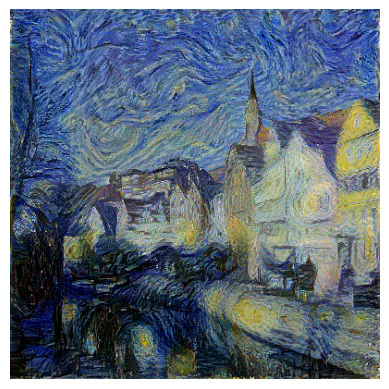

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=1000,
    alpha=30.0,
    beta=500.0
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/1000, Loss: 5.435796899490148e+20, Time: 0.06s
Iteration 100/1000, Loss: 1.3574735483266662e+18, Time: 0.10s
Iteration 200/1000, Loss: 5.631535692308808e+17, Time: 0.10s
Iteration 300/1000, Loss: 3.472670380974408e+17, Time: 0.10s
Iteration 400/1000, Loss: 2.7462244228923392e+17, Time: 0.10s
Iteration 500/1000, Loss: 1.9640945574150144e+17, Time: 0.10s
Iteration 600/1000, Loss: 1.8300091144077312e+17, Time: 0.10s
Iteration 700/1000, Loss: 1.4519014967056794e+17, Time: 0.10s
Iteration 800/1000, Loss: 1.2665808734283366e+17, Time: 0.10s
Iteration 900/1000, Loss: 2.3969989140676608e+17, Time: 0.10s
Total Time: 103.29s


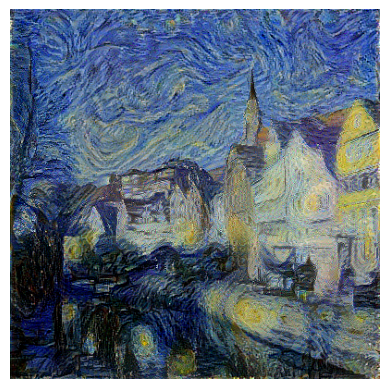

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage.jpg"

result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=1000,
    alpha=150.0,
    beta=500.0
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/1000, Loss: 8.614303377444045e+16, Time: 0.08s
Iteration 100/1000, Loss: 770077368516608.0, Time: 0.10s
Iteration 200/1000, Loss: 276928485392384.0, Time: 0.11s
Iteration 300/1000, Loss: 145041297244160.0, Time: 0.11s
Iteration 400/1000, Loss: 99239573061632.0, Time: 0.10s
Iteration 500/1000, Loss: 173311610847232.0, Time: 0.10s
Iteration 600/1000, Loss: 63475632046080.0, Time: 0.10s
Iteration 700/1000, Loss: 82910619107328.0, Time: 0.10s
Iteration 800/1000, Loss: 97705967747072.0, Time: 0.10s
Iteration 900/1000, Loss: 40546785558528.0, Time: 0.11s
Total Time: 103.79s


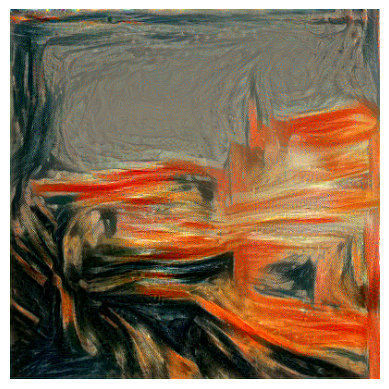

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage2.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=1000,
    alpha=5.0,
    beta=0.1
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/50, Loss: 4307151581347840.0, Time: 0.06s
Total Time: 4.86s


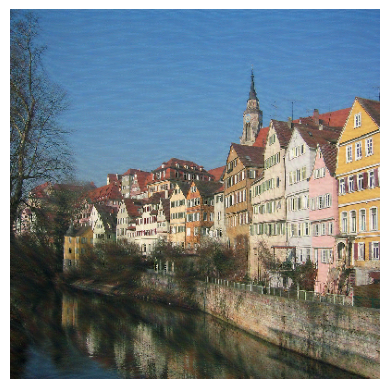

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage2.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=50,
    alpha=1.0,
    beta=0.005
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/50, Loss: 4307151581347840.0, Time: 0.06s
Total Time: 4.90s


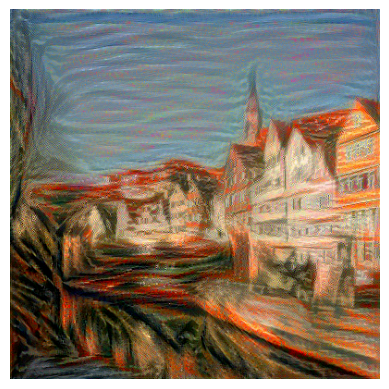

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage2.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=50,
    alpha=1.0,
    beta=0.005
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/500, Loss: 86143026593792.0, Time: 0.06s
Iteration 100/500, Loss: 4997306122240.0, Time: 0.10s
Iteration 200/500, Loss: 2117379948544.0, Time: 0.10s
Iteration 300/500, Loss: 1082674380800.0, Time: 0.10s
Iteration 400/500, Loss: 619934711808.0, Time: 0.10s
Total Time: 51.06s


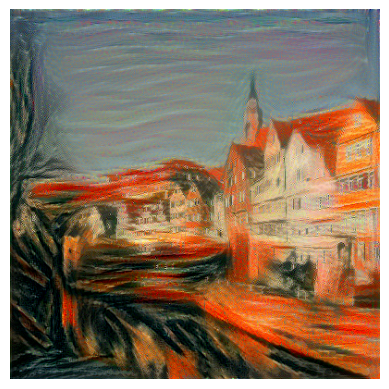

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage2.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=500,
    alpha=1e-3,
    beta=1e-4
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/500, Loss: 5.492627928741052e+18, Time: 0.06s
Iteration 100/500, Loss: 1.3389422247333069e+17, Time: 0.10s
Iteration 200/500, Loss: 5.09765330445271e+16, Time: 0.10s
Iteration 300/500, Loss: 2.813364854901965e+16, Time: 0.10s
Iteration 400/500, Loss: 1.907385312477184e+16, Time: 0.10s
Total Time: 50.52s


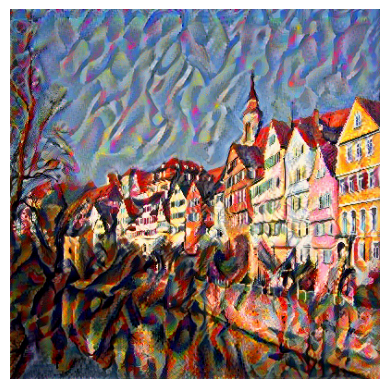

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage3.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=500,
    alpha=1e-3,
    beta=1
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/500, Loss: 5.492627928741052e+18, Time: 0.11s
Iteration 100/500, Loss: 1.3390240009106227e+17, Time: 0.10s
Iteration 200/500, Loss: 5.097716869968691e+16, Time: 0.11s
Iteration 300/500, Loss: 2.813610741779661e+16, Time: 0.10s
Iteration 400/500, Loss: 1.9077521026842624e+16, Time: 0.10s
Total Time: 51.44s


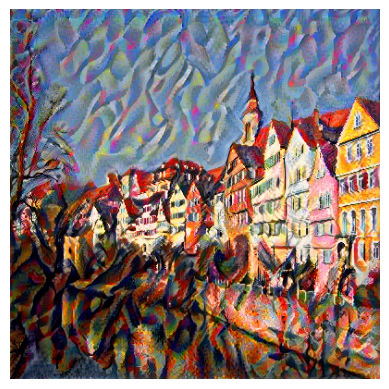

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage3.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=500,
    alpha=8e-4,
    beta=1
)
plt.imshow(result)
plt.axis('off')
plt.show()

Testing alpha=0.5, beta=10, iterations=50
Iteration 0/50, Loss: 5.4926279287410524e+19, Time: 0.06s
Total Time: 4.89s
Testing alpha=0.5, beta=10, iterations=100
Iteration 0/100, Loss: 5.4926279287410524e+19, Time: 0.10s
Total Time: 9.91s
Testing alpha=0.5, beta=10, iterations=150
Iteration 0/150, Loss: 5.4926279287410524e+19, Time: 0.06s
Iteration 100/150, Loss: 1.8044604155481293e+17, Time: 0.10s
Total Time: 15.04s
Testing alpha=0.5, beta=20, iterations=50
Iteration 0/50, Loss: 1.0985255857482105e+20, Time: 0.07s
Total Time: 4.90s
Testing alpha=0.5, beta=20, iterations=100
Iteration 0/100, Loss: 1.0985255857482105e+20, Time: 0.07s
Total Time: 10.08s
Testing alpha=0.5, beta=20, iterations=150
Iteration 0/150, Loss: 1.0985255857482105e+20, Time: 0.06s
Iteration 100/150, Loss: 3.6072897743159296e+17, Time: 0.10s
Total Time: 15.31s
Testing alpha=0.5, beta=30, iterations=50
Iteration 0/50, Loss: 1.6477882906613855e+20, Time: 0.07s
Total Time: 4.97s
Testing alpha=0.5, beta=30, iterations=10

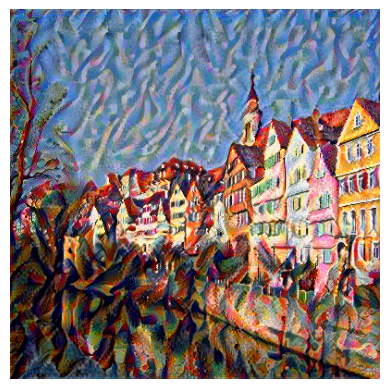

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hàm thử nghiệm các tổ hợp thông số
def optimize_style_transfer(content_path, style_path, alpha_values, beta_values, iteration_values):
    best_result = None
    best_score = float('inf')  # Giá trị thấp hơn là tốt hơn
    best_params = None

    for alpha in alpha_values:
        for beta in beta_values:
            for iters in iteration_values:
                print(f"Testing alpha={alpha}, beta={beta}, iterations={iters}")
                result = style_transfer(content_path, style_path, iterations=iters, alpha=alpha, beta=beta)

                # Đánh giá ảnh kết quả, ví dụ dùng độ lệch chuẩn pixel
                score = np.std(result)  # Cách đánh giá này có thể thay đổi tùy nhu cầu

                if score < best_score:
                    best_score = score
                    best_result = result
                    best_params = (alpha, beta, iters)

    print(f"Best params: alpha={best_params[0]}, beta={best_params[1]}, iterations={best_params[2]}")
    return best_result, best_params

# Giá trị cần thử nghiệm
alpha_values = [0.5, 1.0, 1.5]
beta_values = [10, 20, 30]
iteration_values = [50, 100, 150]

result, best_params = optimize_style_transfer(content_path, style_path, alpha_values, beta_values, iteration_values)
plt.imshow(result)
plt.axis('off')
plt.show()


Iteration 0/500, Loss: 1.641730426894549e+18, Time: 0.06s
Iteration 100/500, Loss: 4.26854293920809e+16, Time: 0.10s
Iteration 200/500, Loss: 2.096167163999027e+16, Time: 0.10s
Iteration 300/500, Loss: 1.3868566436642816e+16, Time: 0.10s
Iteration 400/500, Loss: 1.0098932696743936e+16, Time: 0.10s
Total Time: 51.52s


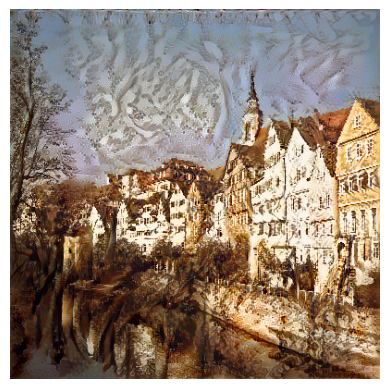

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage4.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=500,
    alpha=1e-3,
    beta=1
)
plt.imshow(result)
plt.axis('off')
plt.show()

Iteration 0/300, Loss: 1.6417304988026094e+23, Time: 0.06s
Iteration 100/300, Loss: 4.268582095565934e+21, Time: 0.10s
Iteration 200/300, Loss: 2.096188061660622e+21, Time: 0.10s
Total Time: 30.79s


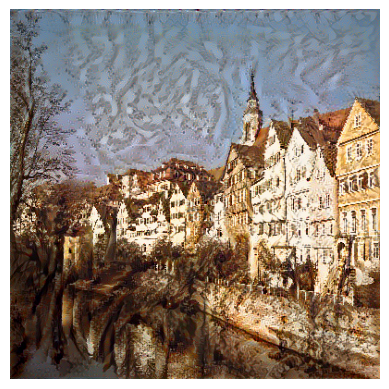

In [ ]:
content_path = "/content/contentimage.jpg"
style_path = "/content/styleimage4.jpg"
result = style_transfer(
    content_path=content_path,
    style_path=style_path,
    iterations=300,
    alpha=1e-15,
    beta=1e5
)
plt.imshow(result)
plt.axis('off')
plt.show()